# **Demand Forecasting Optimization for Corporation Favorita A Time Series Regression ML Approach**

### Table of Contents
1. [Business Understanding](#business-understanding)
2. [Data collection](#Data-collection)
3. [Data Cleaning and Preparation](#Data-Cleaning-and-Preparation)
4. [Hypotheses](#hypotheses)
5. [Analytical Questions](#analytical-questions)
6. [Data Sources](#data-sources)
7. [Process Overview](#process-overview)

## **Business Understanding**

Corporation Favorita, a large grocery retailer based in Ecuador, aims to optimize its inventory management to ensure the right quantity of products is always in stock across its various locations. Effective inventory management is critical for maintaining high levels of customer satisfaction and minimizing costs associated with overstocking or stockouts.

To achieve this goal, we will build machine learning models to forecast the demand for products at different Favorita stores. Accurate demand forecasting will allow Corporation Favorita to make informed decisions regarding stock levels, promotions, and supply chain logistics.

#### Objective:
1. **Develop Predictive Models**: Create models to forecast daily unit sales for thousands of products across multiple stores.
2. **Understand Influencing Factors**: Analyze the impact of various factors on sales, including promotions, holidays, oil prices, store characteristics, and external events such as earthquakes.
3. **Optimize Inventory Management**: Use the models to inform inventory decisions, ensuring that the right products are available at the right stores at the right time.

#### Hypothesis:
1. Null Hypothesis (H0): Promotions do not have a significant impact on sales.  
   Alternative Hypothesis (H1): Promotions have a significant impact on sales.
2. Null Hypothesis (H0): Oil prices do not significantly impact sales.  
   Alternative Hypothesis (H1): Oil prices significantly impact sales.

#### Key Analytical Questions:
1. **Data Completeness**: Is the training dataset complete with all required dates?
2. **Sales Extremes**: Which dates have the lowest and highest sales for each year (excluding days when stores were closed)?
3. **Monthly Sales Trends**: Compare sales across months and years to identify the highest sales month and year.
4. **Earthquake Impact**: Did the earthquake in April 2016 impact sales?
5. **Store Performance**: Are certain stores or groups of stores (cluster, city, state, type) selling more products?
6. **Promotions, Oil Prices, and Holidays**: How are sales affected by promotions, oil prices, and holidays?
7. **Date Features Analysis**: What insights can be derived from date-related features?
8. **Promotion Impact**: Which product families and stores were most affected by promotions?
9. **Error Metrics**: What is the difference between RMSLE, RMSE, and MSE? Why might MAE be greater than these metrics?
10. **Wage Payment Influence**: Does the bi-monthly payment of public sector wages influence store sales?


#### Data Sources
- **train.csv**: Time series data of store, product information, promotions, and sales.
- **test.csv**: Features similar to the training data for the 15 days following the last date in the training data.
- **transaction.csv**: Daily transactions per store.
- **stores.csv**: Metadata about stores including location and type.
- **oil.csv**: Daily oil prices.
- **holidays_events.csv**: Information about holidays and events, including special designations like transferred, bridge, and work days.
- **sample_submission.csv**: A sample submission file for formatting predictions.


## **Importing Necessary packages**

In [76]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy import stats
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')


# Seaborn color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

# Function to format y-axis labels in millions
def millions(x, pos):
    return '%1.0fM' % (x * 1e-6)

## **Data Collection**

In [15]:
# Loading environment variables from .env file
environment_variables = dotenv_values('.env')

# Getting the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Creating a connection string
connection_string = f"DRIVER={{SQL Server}}; \
                    SERVER={server}; \
                    DATABASE={database}; \
                    UID={username}; \
                    PWD={password};"

# Connecting to the server
connection = pyodbc.connect(connection_string)

Loading data from the database

In [16]:
# Loading Oil dataset
oil = pd.read_sql_query("SELECT * FROM dbo.oil", connection)

# Saving the DataFrame to a CSV file
oil.to_csv('data/oil.csv', index=False)

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [17]:
# Loading holidays_events dataset
holidays_events = pd.read_sql_query(
    "SELECT * FROM dbo.holidays_events", connection)

# Saving the DataFrame to a CSV file
holidays_events.to_csv('data/holidays_events.csv', index=False)

holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [18]:
# Loading stores dataset
stores = pd.read_sql_query("SELECT * FROM dbo.stores", connection)

# Saving the DataFrame to a CSV file
stores.to_csv('data/stores.csv', index=False)

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
train = pd.read_csv('Data/train.csv')

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [20]:
test = pd.read_csv('Data/test.csv')

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [21]:
transactions = pd.read_csv('Data/transactions.csv')

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [22]:
sample_submission = pd.read_csv('Data/sample_submission.csv')

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


## **Data Cleaning and Preparation**

1. Missing Values Handling

In [23]:
# Checking for missing values in each dataset
missing_values_train = train.isnull().sum()
missing_values_test = test.isnull().sum()
missing_values_transactions = transactions.isnull().sum()
missing_values_stores = stores.isnull().sum()
missing_values_oil = oil.isnull().sum()
missing_values_holidays_events = holidays_events.isnull().sum()
missing_values_sample_submission = sample_submission.isnull().sum()

missing_values_train, missing_values_test, missing_values_transactions, missing_values_stores, missing_values_oil, missing_values_holidays_events, missing_values_sample_submission

(id             0
 date           0
 store_nbr      0
 family         0
 sales          0
 onpromotion    0
 dtype: int64,
 id             0
 date           0
 store_nbr      0
 family         0
 onpromotion    0
 dtype: int64,
 date            0
 store_nbr       0
 transactions    0
 dtype: int64,
 store_nbr    0
 city         0
 state        0
 type         0
 cluster      0
 dtype: int64,
 date           0
 dcoilwtico    43
 dtype: int64,
 date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64,
 id       0
 sales    0
 dtype: int64)

In [24]:
# Filling missing values in the oil dataset using forward fill
oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Verifying that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    1
dtype: int64

In [25]:
# Filling the remaining missing value using backward fill
oil['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verifying that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    0
dtype: int64

2. Data Types Correction

In [26]:
# Converting date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

3. Merging Datasets

In [29]:
# Merging train dataset with transactions, stores, oil, and holidays_events
train_merged = train.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(holidays_events, on='date', how='left')

# Repeating the same for the test dataset
test_merged = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test_merged = test_merged.merge(stores, on='store_nbr', how='left')
test_merged = test_merged.merge(oil, on='date', how='left')
test_merged = test_merged.merge(holidays_events, on='date', how='left')

In [31]:
# necessary renames 
train_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)
test_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)

In [35]:
# Filling null values in transactions with 0
train_merged['transactions'].fillna(0, inplace=True)
test_merged['transactions'].fillna(0, inplace=True)

# Forward filling and backward filling for dcoilwtico
train_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
train_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

test_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
test_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

# Filling holiday-related columns with 'None'
holiday_related_cols = ['holiday_type', 'locale','locale_name', 'description', 'transferred']
train_merged[holiday_related_cols] = train_merged[holiday_related_cols].fillna('None')
test_merged[holiday_related_cols] = test_merged[holiday_related_cols].fillna('None')

4. Creating Date Features

In [36]:
# Create additional features from the date
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month
train_merged['day'] = train_merged['date'].dt.day
train_merged['dayofweek'] = train_merged['date'].dt.dayofweek

test_merged['year'] = test_merged['date'].dt.year
test_merged['month'] = test_merged['date'].dt.month
test_merged['day'] = test_merged['date'].dt.day
test_merged['dayofweek'] = test_merged['date'].dt.dayofweek

5. Handling Categorical Variables

In [ ]:
# Convert categorical variables to numeric using one-hot encoding
categorical_columns = ['family', 'city', 'state', 'store_type',
                       'holiday_type', 'locale', 'locale_name', 'description', 'transferred']
train_final = pd.get_dummies(
    train_merged, columns=categorical_columns, drop_first=True)
test_final = pd.get_dummies(
    test_merged, columns=categorical_columns, drop_first=True)

## **Exploratory Data Analysis (EDA)**

In [39]:
# Grouping by date and sum sales to get the overall sales trend over time
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# Grouping by year and month for monthly trend
sales_trend['year_month'] = sales_trend['date'].dt.to_period('M')
monthly_sales_trend = sales_trend.groupby(
    'year_month')['sales'].sum().reset_index()

# Grouping by year for yearly trend
sales_trend['year'] = sales_trend['date'].dt.year
yearly_sales_trend = sales_trend.groupby('year')['sales'].sum().reset_index()

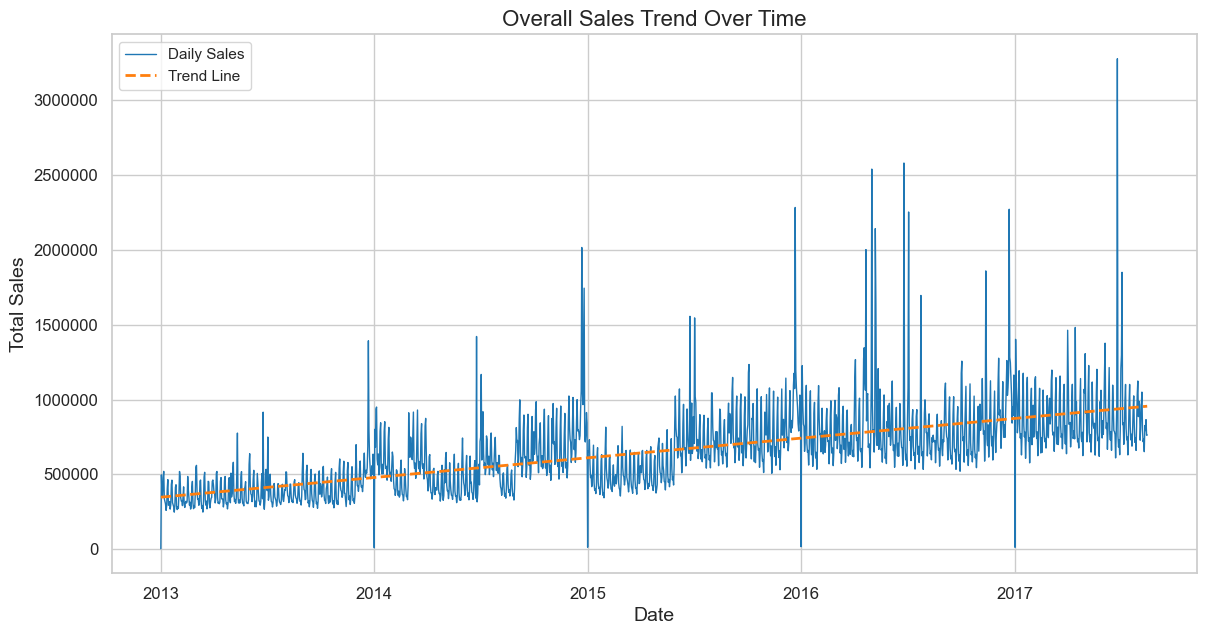

In [54]:
# Plotting overall sales trend
plt.figure(figsize=(14, 7))
plt.plot(sales_trend['date'], sales_trend['sales'],
         color=palette[0], linewidth=1, label='Daily Sales')
plt.title('Overall Sales Trend Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# Formatting y-axis to avoid exponents
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# Adding a trend line for better visualization
z = np.polyfit(sales_trend['date'].apply(lambda x: x.toordinal()), sales_trend['sales'], 1)
p = np.poly1d(z)
plt.plot(sales_trend['date'], p(sales_trend['date'].apply(lambda x: x.toordinal())), 
         color=palette[1], linestyle='--', linewidth=2, label='Trend Line')

plt.legend()
plt.show()

1. **Overall Increasing Trend**:
   - The trend line indicates a gradual increase in overall sales from 2013 to 2017. This suggests a positive growth trajectory in sales over the years.

2. **Seasonal Peaks and Troughs**:
   - There are noticeable peaks and troughs in the sales data, which could be attributed to seasonal effects, holidays, or promotional events. These fluctuations indicate that certain periods experience higher sales volumes.

3. **Sharp Spikes**:
   - Several sharp spikes are observed throughout the timeline. These spikes might correspond to specific high-demand events, major holidays, or significant promotional campaigns that led to a sudden increase in sales.

4. **Consistency in Sales**:
   - Despite the fluctuations, there is a consistent pattern in the daily sales, with the values generally falling within a specific range. This consistency indicates a stable sales performance with periodic increases.

5. **Impact of Holidays and Events**:
   - Some of the peaks align with well-known holidays or events, suggesting that these occasions have a substantial impact on sales. Understanding these patterns can help in planning inventory and marketing strategies.

6. **Possible Declines**:
   - The trend line also helps identify periods where sales might not have grown as expected or could have experienced slight declines. These periods require further investigation to understand the underlying causes and address them effectively.


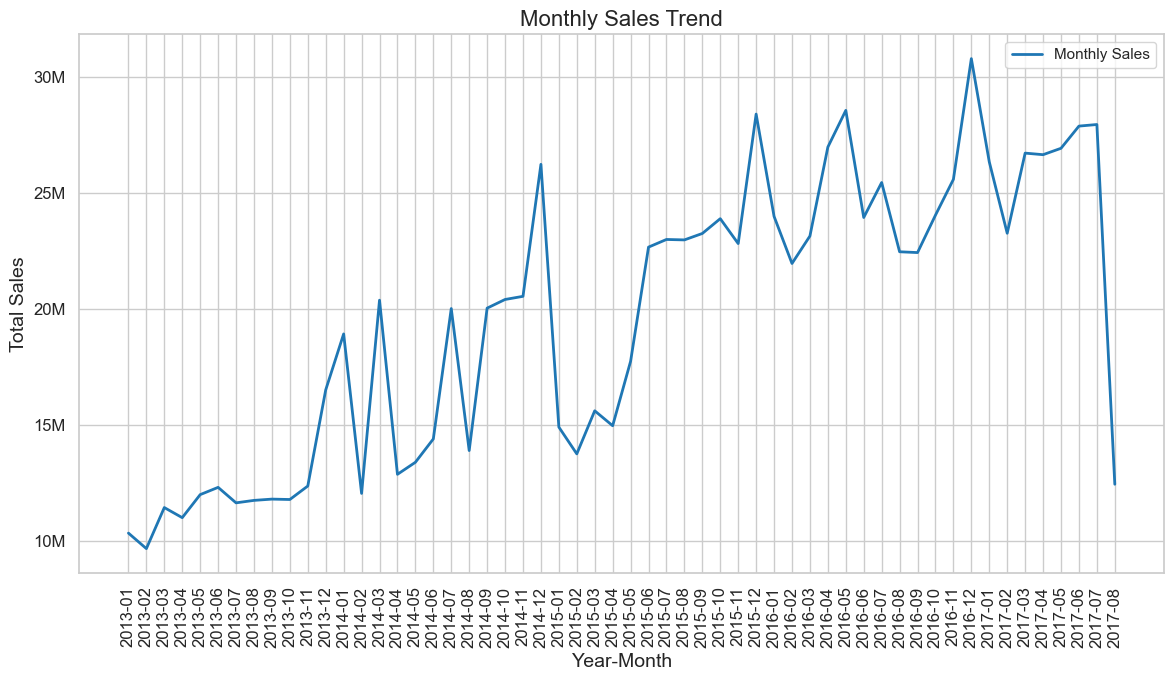

In [67]:
# Plotting monthly sales trend
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales_trend['year_month'].astype(str), 
         monthly_sales_trend['sales'], color=palette[0], linewidth=2, label='Monthly Sales')
plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=90)

# Formatting y-axis exponents
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.legend()
plt.show()

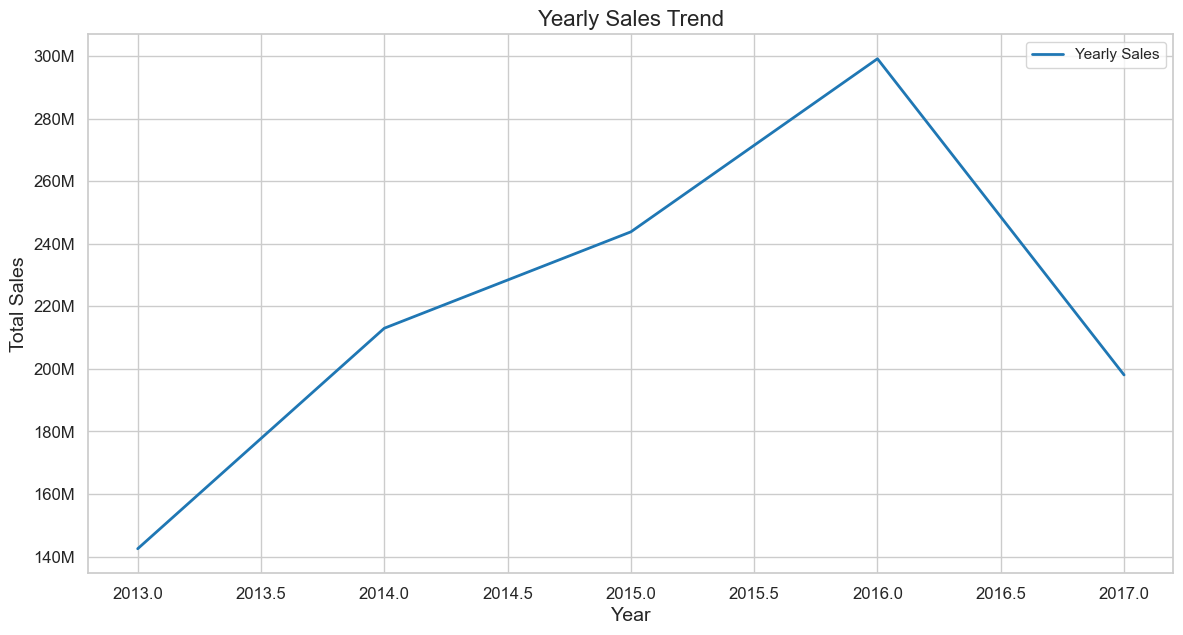

In [66]:
# Plotting yearly sales trend
plt.figure(figsize=(14, 7))
plt.plot(yearly_sales_trend['year'], yearly_sales_trend['sales'],
         color=palette[0], linewidth=2, label='Yearly Sales')
plt.title('Yearly Sales Trend', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.legend()
plt.show()

### Seasonality and Monthly Sales Patterns

<Figure size 1400x700 with 0 Axes>

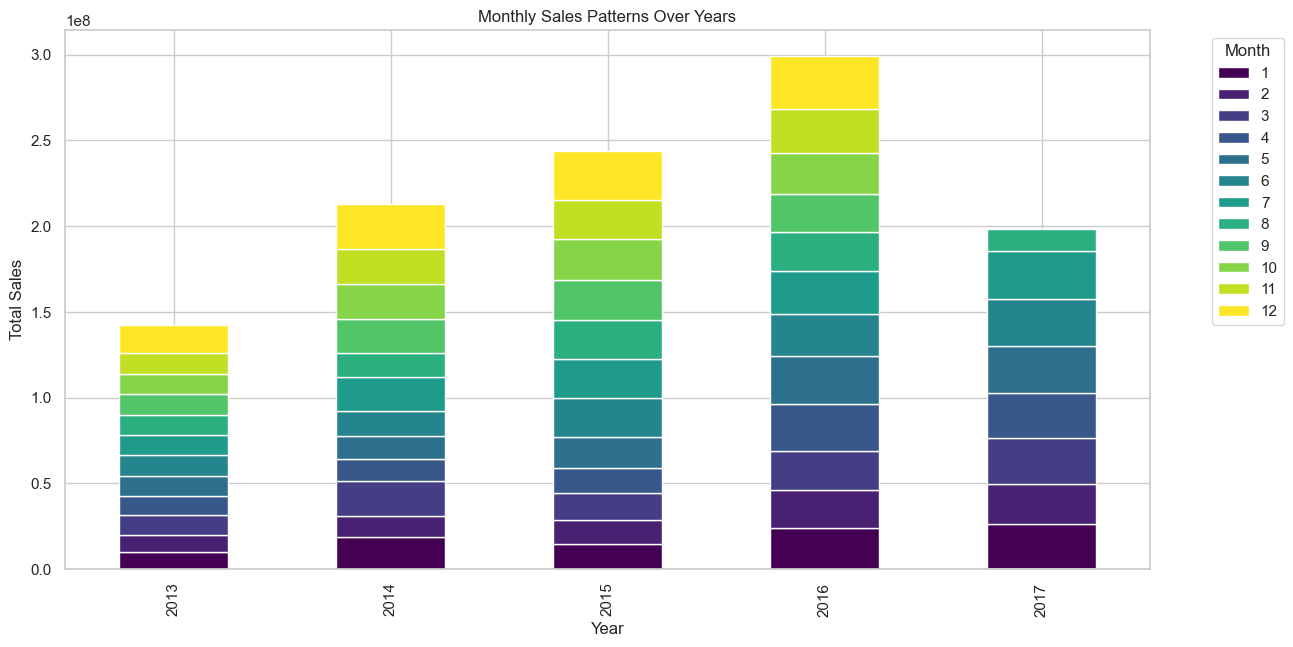

In [69]:
# Aggregate sales by month and year
monthly_sales = train_merged.groupby(['year', 'month'])[
    'sales'].sum().unstack()

# Plot monthly sales patterns
plt.figure(figsize=(14, 7))
monthly_sales.plot(kind='bar', stacked=True,
                   colormap='viridis', figsize=(14, 7))
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Patterns Over Years')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Sales Distribution Across Stores and Product Families

In [ ]:
# Aggregate sales by store and product family
store_sales = train_merged.groupby('store_nbr')['sales'].sum(
).sort_values(ascending=False).reset_index()
family_sales = train_merged.groupby(
    'family')['sales'].sum().sort_values(ascending=False).reset_index()

# Plot sales distribution across stores
plt.figure(figsize=(14, 7))
plt.bar(store_sales['store_nbr'], store_sales['sales'])
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Sales Distribution Across Stores')
plt.show()

In [ ]:
# Plot sales distribution across product families
plt.figure(figsize=(14, 7))
plt.barh(family_sales['family'], family_sales['sales'])
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.title('Sales Distribution Across Product Families')
plt.show()

### Impact of Promotions

In [ ]:
# Aggregate sales by promotion status
promotion_sales = train_merged.groupby(
    'onpromotion')['sales'].sum().reset_index()

# Plot impact of promotions on sales
plt.figure(figsize=(10, 6))
plt.bar(promotion_sales['onpromotion'],
        promotion_sales['sales'], color=['blue', 'orange'])
plt.xlabel('On Promotion')
plt.ylabel('Total Sales')
plt.title('Impact of Promotions on Sales')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

### Impact of Oil Prices

In [ ]:
# Plot sales versus oil prices
plt.figure(figsize=(14, 7))
plt.plot(train_merged['date'], train_merged['sales'], label='Sales')
plt.plot(train_merged['date'], train_merged['dcoilwtico'],
         label='Oil Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sales vs Oil Prices')
plt.legend()
plt.show()

### Impact of Holidays

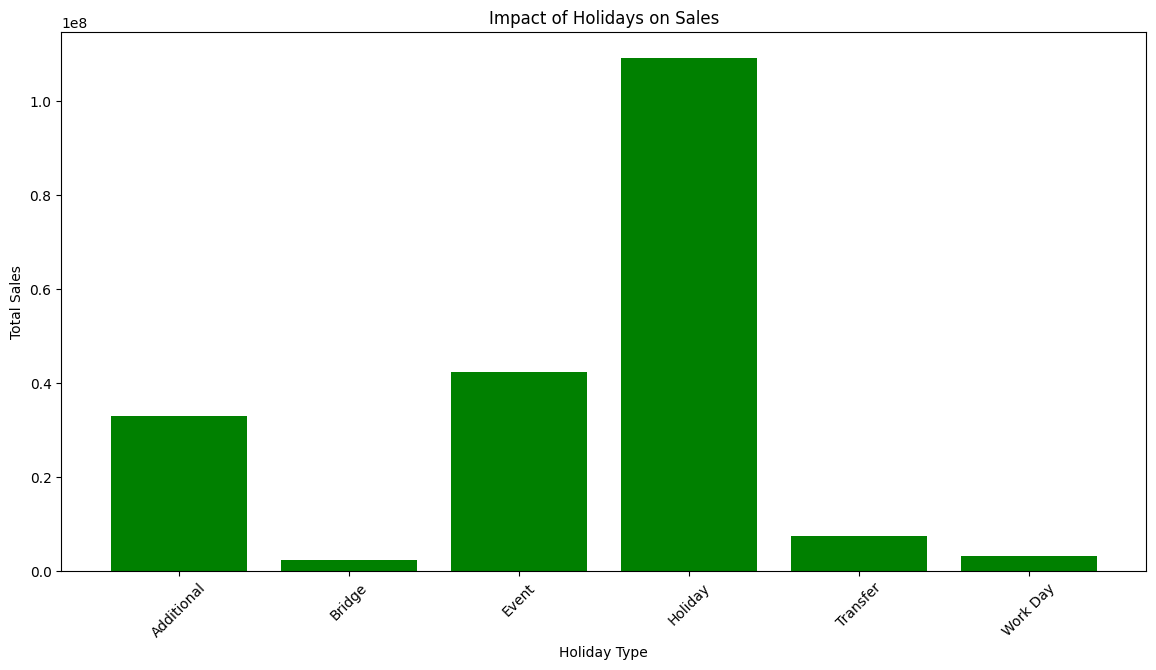

In [32]:
# Aggregate sales by holiday status
holiday_sales = train_merged.groupby(
    'holiday_type')['sales'].sum().reset_index()

# Plot impact of holidays on sales
plt.figure(figsize=(14, 7))
plt.bar(holiday_sales['holiday_type'], holiday_sales['sales'], color='green')
plt.xlabel('Holiday Type')
plt.ylabel('Total Sales')
plt.title('Impact of Holidays on Sales')
plt.xticks(rotation=45)
plt.show()

## **Hypothesis Testing**

Null Hypothesis (H0a): Promotions do not have a significant impact on sales.  

Alternative Hypothesis (H1a): Promotions have a significant impact on sales.

In [73]:
# Splitting the data into promotional and non-promotional periods
promotional_sales = train[train['onpromotion'] > 0]['sales']
non_promotional_sales = train[train['onpromotion'] == 0]['sales']

# Calculating descriptive statistics
promotional_mean = promotional_sales.mean()
non_promotional_mean = non_promotional_sales.mean()
promotional_std = promotional_sales.std()
non_promotional_std = non_promotional_sales.std()

print(f"Promotional Sales - Mean: {promotional_mean}, Std: {promotional_std}")
print(f"Non-Promotional Sales - Mean: {non_promotional_mean}, Std: {non_promotional_std}")


Promotional Sales - Mean: 1137.6937303133943, Std: 1928.5887066373123
Non-Promotional Sales - Mean: 158.2466813936427, Std: 614.8944509454778


In [72]:
# Performing t-test
t_stat, p_value = ttest_ind(promotional_sales, non_promotional_sales)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpreting the results
alpha = 0.05
if p_value < alpha:
    print("We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis (H0a). Promotions do not have a significant impact on sales.")

T-Statistic: 664.1236909096903, P-Value: 0.0
We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.


Null Hypothesis (H0b): Oil prices do not significantly impact sales.  

Alternative Hypothesis (H1b): Oil prices significantly impact sales.

In [75]:
# Removing rows with missing oil prices
oil_merged_data = train_merged.dropna(subset=['dcoilwtico'])

# Performing correlation analysis
correlation = oil_merged_data['sales'].corr(oil_merged_data['dcoilwtico'])
print(f"Correlation between sales and oil prices: {correlation}")

Correlation between sales and oil prices: -0.07542992345237809


In [78]:
# Performing linear regression analysis
X = oil_merged_data['dcoilwtico']
y = oil_merged_data['sales']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 1.748e+04
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:57:19   Log-Likelihood:            -2.5735e+07
No. Observations:             3054348   AIC:                         5.147e+07
Df Residuals:                 3054346   BIC:                         5.147e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        579.8744      1.786    324.672      0.000     576.374     583.375
dcoilwtico    -3.2545      0.025   -132.203      0.000      -3.303      -3.206
==============================================================================
Omnibus:                  4181597.532   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3529592884.706
Skew:                           7.486   Prob(JB):                         0.00
Kurtosis:                     168.862   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
# Extract the p-value for the oil price coefficient
p_value = model.pvalues['dcoilwtico']
print(f"P-Value for oil prices: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0b). Oil prices significantly impact sales.")
else:
    print("Fail to reject the null hypothesis (H0b). Oil prices do not significantly impact sales.")

P-Value for oil prices: 0.0
Reject the null hypothesis (H0b). Oil prices significantly impact sales.


## **Analytical Questions**

### 1. Is the train dataset complete (has all the required dates)?

In [ ]:
train_merged['date'].min(), train_merged['date'].max()

In [ ]:
# getting dates which are not in the train dataset
missing_dates = pd.date_range(
    start='2013-01-01', end='2017-08-15').difference(train_merged.date)

# print(pd.date_range(start= '2013-01-01', end='2017-08-15').difference(train.index))
missing_dates

In [ ]:
# creating variables as arguments for the product() method
uniques_stores = train_merged.store_nbr.unique()
unique_family = train_merged.family.unique()

In [ ]:
# we will replace the missing dates by pairing it with all the unique stores and families
replace_dates = list(product(missing_dates, uniques_stores,unique_family ))

In [ ]:
# creating a dataframe for the replaced dates
replace_dates_df = pd.DataFrame(
    replace_dates, columns=['date', 'store_nbr', 'family'])
replace_dates_df.head()

In [ ]:
# adding replaced dates to our train data
train_merged = pd.concat([train_merged, replace_dates_df], ignore_index=True)
train_merged.head()

In [ ]:
missing_dates = pd.date_range(
    start='2013-01-01', end='2017-08-15').difference(train_merged.date)
missing_dates

### 2. Which dates have the lowest and highest sales for each year(excluding days the store was closed)?

In [ ]:
# Identify dates when stores were closed (i.e., zero transactions)
closed_dates = transactions[transactions['transactions'] == 0]['date'].unique()

# Filter out closed dates from the sales data
sales_data = train_merged[~train_merged['date'].isin(closed_dates)]

In [ ]:
# Extract year from the date
sales_data['year'] = sales_data['date'].dt.year

# Group by year and date, then sum the sales
yearly_sales = sales_data.groupby(['year', 'date'])[
    'sales'].sum().reset_index()

### 3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

### 3. Did the earthquake impact sales?

Note:A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [ ]:
# Define the pre-earthquake and post-earthquake periods
pre_earthquake = train_merged[train_merged['date'] < '2016-04-16']
post_earthquake = train_merged[train_merged['date'] >= '2016-04-16']

In [ ]:
# Aggregate sales data for pre-earthquake and post-earthquake periods
pre_earthquake_sales = pre_earthquake.groupby(
    'date')['sales'].sum().reset_index()
post_earthquake_sales = post_earthquake.groupby(
    'date')['sales'].sum().reset_index()

In [ ]:
# Plot sales over time, highlighting the earthquake date
plt.figure(figsize=(14, 7))
plt.plot(pre_earthquake_sales['date'],
         pre_earthquake_sales['sales'], label='Pre-Earthquake')
plt.plot(post_earthquake_sales['date'], post_earthquake_sales['sales'],
         label='Post-Earthquake', color='orange')
plt.axvline(pd.to_datetime('2016-04-16'), color='red',
            linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Before and After the Earthquake on April 16, 2016')
plt.legend()
plt.show()

In [ ]:
# Perform t-test to compare sales before and after the earthquake
from scipy.stats import ttest_ind

# Combine sales data for t-test
pre_earthquake_sales_total = pre_earthquake_sales['sales']
post_earthquake_sales_total = post_earthquake_sales['sales']

# Perform t-test
t_stat_earthquake, p_value_earthquake = ttest_ind(
    pre_earthquake_sales_total, post_earthquake_sales_total)

t_stat_earthquake, p_value_earthquake

### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [ ]:
# Aggregate sales by cluster
cluster_sales = train_merged.groupby('cluster')['sales'].sum().reset_index()

# Aggregate sales by city
city_sales = train_merged.groupby('city')['sales'].sum().reset_index()

# Aggregate sales by state
state_sales = train_merged.groupby('state')['sales'].sum().reset_index()

# Aggregate sales by store type
store_type_sales = train_merged.groupby('store_type')['sales'].sum().reset_index()

Sales by Cluster

In [ ]:
plt.figure(figsize=(14, 7))
plt.bar(cluster_sales['cluster'], cluster_sales['sales'])
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.title('Total Sales by Cluster')
plt.show()

Sales by City

In [ ]:
plt.figure(figsize=(14, 7))
plt.bar(city_sales['city'], city_sales['sales'])
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.title('Total Sales by City')
plt.xticks(rotation=90)
plt.show()

Sales by state

In [ ]:
plt.figure(figsize=(14, 7))
plt.bar(state_sales['state'], state_sales['sales'])
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Total Sales by State')
plt.xticks(rotation=90)
plt.show()

Sales by Store Type

In [ ]:
plt.figure(figsize=(14, 7))
plt.bar(store_type_sales['store_type'], store_type_sales['sales'])
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Type')
plt.show()

### 5. Are sales affected by promotions, oil prices and holidays?

Impact of Promotions on Sales

In [ ]:
import seaborn as sns
from scipy.stats import ttest_ind

# Create box plot for promotions
plt.figure(figsize=(14, 7))
sns.boxplot(x='onpromotion', y='sales', data=train_merged)
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.title('Impact of Promotions on Sales')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Perform t-test for promotions
promoted_sales = train_merged[train_merged['onpromotion'] > 0]['sales']
non_promoted_sales = train_merged[train_merged['onpromotion'] == 0]['sales']
t_stat_promotions, p_value_promotions = ttest_ind(
    promoted_sales, non_promoted_sales)

t_stat_promotions, p_value_promotions

Impact of Oil Prices on Sales

In [ ]:
from scipy.stats import pearsonr

# Create scatter plot for oil prices
plt.figure(figsize=(14, 7))
plt.scatter(train_merged['dcoilwtico'], train_merged['sales'], alpha=0.3)
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Impact of Oil Prices on Sales')
plt.show()

# Compute Pearson correlation for oil prices
correlation_oil, p_value_oil = pearsonr(
    train_merged['sales'], train_merged['dcoilwtico'])

correlation_oil, p_value_oil

Impact of Holidays on Sales

In [ ]:
# Create box plot for holidays
plt.figure(figsize=(14, 7))
sns.boxplot(x='holiday_type', y='sales', data=train_merged)
plt.xlabel('Holiday Type')
plt.ylabel('Sales')
plt.title('Impact of Holidays on Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Perform t-test for holidays
holiday_sales = train_merged[train_merged['holiday_type'] != 'None']['sales']
non_holiday_sales = train_merged[train_merged['holiday_type'] == 'None']['sales']
t_stat_holidays, p_value_holidays = ttest_ind(holiday_sales, non_holiday_sales)

t_stat_holidays, p_value_holidays